In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (roc_auc_score, roc_curve, confusion_matrix,
                             classification_report, f1_score)
import random
import tensorflow as tf


# Répétabilité
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [34]:
# Charger les données prétraitées
df = pd.read_csv("../data/Customers_cleaned.csv")

In [35]:
# Séparation features/target
y = (df['Churn'] == 'Yes').astype(int)
X = df.drop(['Churn', 'customerID'], axis=1)

# Définition des colonnes
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Création du preprocesseur
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ]
)

# Split des données (train/val/test stratifié)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=SEED, stratify=y_temp
)

# Fit/transform sur train, transform sur val/test
X_train_prep = preprocessor.fit_transform(X_train)
X_val_prep = preprocessor.transform(X_val)
X_test_prep = preprocessor.transform(X_test)

In [36]:
#Création du modèle de regression logistique

logistic_model= LogisticRegression(random_state=SEED, solver='liblinear',
                                   class_weight='balanced')

In [37]:
#Creation du modèle
logistic_model.fit(X_train_prep, y_train)

LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')

In [38]:
#Prédiction sur l'ensemble de validation
y_val_pred= logistic_model.predict(X_val_prep)
y_val_proba = logistic_model.predict_proba(X_val_prep)[:,1]

In [39]:
#Evalution du modèle 
roc_auc = roc_auc_score(y_val, y_val_proba)
f1 = f1_score(y_val, y_val_pred)

print("Baseline (Régression Logistique) :")
print(f"ROC AUC : {roc_auc:.4f}")
print(f"F1 Score : {f1:.4f}")
print("\nRapport de classification :")
print(classification_report(y_val, y_val_pred))

Baseline (Régression Logistique) :
ROC AUC : 0.8479
F1 Score : 0.6306

Rapport de classification :
              precision    recall  f1-score   support

           0       0.91      0.73      0.81       828
           1       0.52      0.80      0.63       299

    accuracy                           0.75      1127
   macro avg       0.72      0.77      0.72      1127
weighted avg       0.81      0.75      0.76      1127



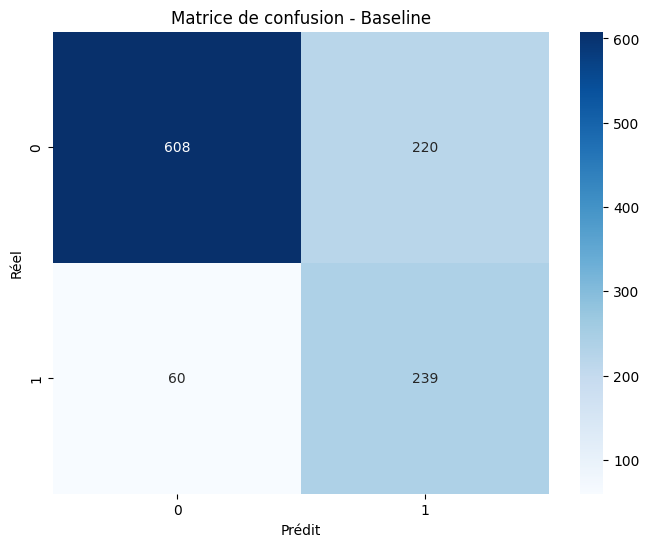

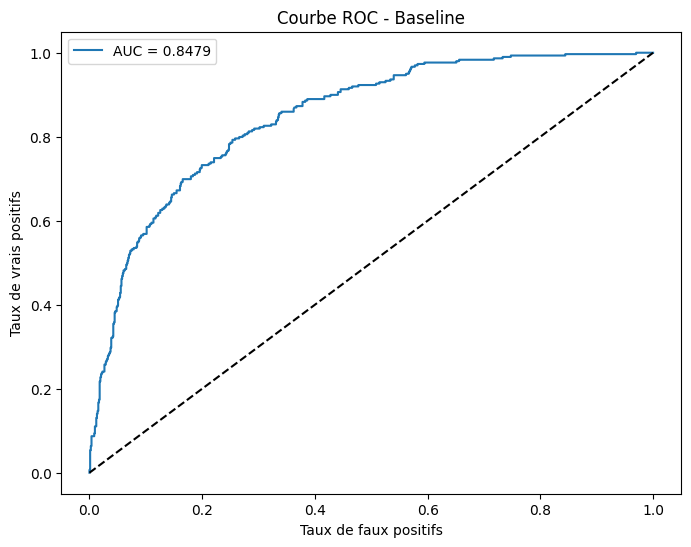

In [40]:
# Matrice de confusion
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de confusion - Baseline')
plt.show()

# Courbe ROC
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_val, y_val_proba)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC - Baseline')
plt.legend()
plt.show()